In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
import keras
from keras.layers import Dense,Dropout,Flatten,BatchNormalization,GlobalAveragePooling2D
from keras.applications import RegNetX280W
from keras.preprocessing.image import ImageDataGenerator as IDG
import cv2
import keras
import pydot
from keras.utils import plot_model


ImportError: cannot import name 'RegNetX280W' from 'keras.applications' (c:\Users\Jaswanth\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\applications\__init__.py)

In [15]:
base='./data2/'
# root_dir='./'
test=base+"test/"
train=base+"train/"
wdr="./dataset4/"
# if os.path.exists(wdr):
#     remove_tree(wdr)
# os.mkdir(wdr)
# copy_tree(train,wdr)
# copy_tree(test,wdr)
print("wdc:",os.listdir(wdr))

wdc: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [16]:
work='./dataset4/'
classes=['glioma', 'meningioma', 'notumor', 'pituitary']
idm=176
ida=[176,208]
DIM=(idm,idm)

In [17]:
train_data_gen=IDG(rescale=1./255)
# train_data_gen=train_data_gen.flow_from_directory(directory=work,target_size=DIM,batch_size=6500)
train_data_gen = train_data_gen.flow_from_directory(directory=work, target_size=DIM, batch_size=10185) #12 for more good res

Found 10185 images belonging to 4 classes.


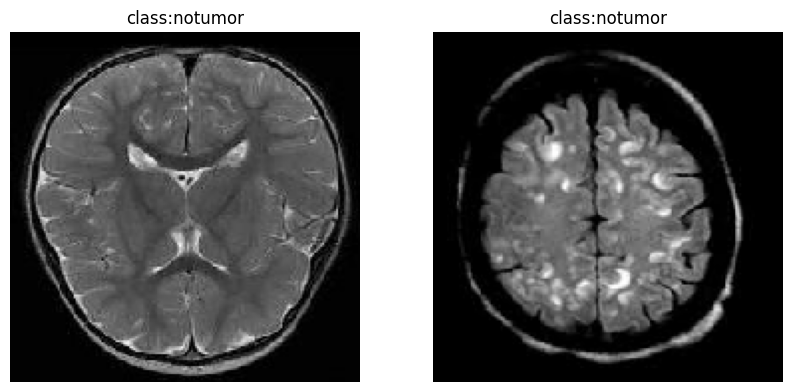

In [18]:
def show_images(generator):
    labels=dict(zip([0,1,2,3],classes))
    x,y=generator.next()
    plt.figure(figsize=(10,10))
    for i in range(2):
        ax=plt.subplot(2,2,i+1)
        idx=randint(0,300)
        plt.imshow(x[idx])
        plt.axis("off")
        plt.title("class:{}".format(labels[np.argmax(y[idx])]))

show_images(train_data_gen)

In [19]:
train_data,train_labels=train_data_gen.next()

In [20]:
sm=SMOTE(random_state=42)
train_data,train_labels=sm.fit_resample(train_data.reshape(-1,idm*idm*3),train_labels)
train_data=train_data.reshape(-1,idm,idm,3)
print(train_data.shape,train_labels.shape)

(10636, 176, 176, 3) (10636, 4)


In [21]:
train_data,test_data,train_labels,test_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)
train_data,val_data,train_labels,val_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)

In [22]:
base_model = RegNetY160(input_shape=(176,176,3),include_top=False,weights="imagenet")
for layer in base_model.layers:
    layer.trainable = False

74836368/74836368 [==============================] - 14s 0us/step


In [23]:
custommodel=tf.keras.Sequential([base_model,Dropout(0.10),
                            GlobalAveragePooling2D(),Flatten(),
                            BatchNormalization(),
                            Dense(512,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.10),
                            Dense(256,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.10),
                            Dense(128,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.10),
                            Dense(64,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.10),
                            Dense(4,activation='softmax'),
                            ],name="Reg_cnn_model")

In [24]:
METRICS=[tf.keras.metrics.CategoricalAccuracy(name='train_acc'),
         tf.keras.metrics.AUC(name='val_acc'),
         tfa.metrics.F1Score(num_classes=4)]
custommodel.compile(loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS)
custommodel.summary()

Model: "Reg_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 5, 5, 1920)        18321984  
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 1920)        0         
                                                                 
 global_average_pooling2d_1  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 batch_normalization_5 (Bat  (None, 1920)              7680      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 512)             

In [25]:
EPOCHS = 25
history = custommodel.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/25
213/213 [==============================] - 441s 2s/step - loss: 0.4027 - train_acc: 0.8559 - val_acc: 0.9717 - f1_score: 0.8542 - val_loss: 0.2392 - val_train_acc: 0.9248 - val_val_acc: 0.9883 - val_f1_score: 0.9268
Epoch 2/25
 16/213 [=>............................] - ETA: 9:58 - loss: 0.2797 - train_acc: 0.8789 - val_acc: 0.9853 - f1_score: 0.8790 

KeyboardInterrupt: 

In [ ]:
fig ,ax=plt.subplots(1,3,figsize=(30,5))
ax=ax.ravel()
for i,metric in enumerate(["train_acc","val_acc","loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_"+metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train","val"])

In [ ]:
test_scores=custommodel.evaluate(test_data,test_labels)
print("Loss: ", test_scores[0])
print("Accuracy: ", test_scores[1])

In [ ]:
pred_labels=custommodel.predict(test_data)

In [ ]:
def roundoff(arr):
    arr[np.argwhere(arr!=arr.max())]=0
    arr[np.argwhere(arr==arr.max())]=1
    return arr
for labels in pred_labels:
    labels=roundoff(labels)
print(classification_report(test_labels,pred_labels,target_names=classes))

In [ ]:
pred_ls=np.argmax(pred_labels,axis=1)
test_ls=np.argmax(test_labels,axis=1)
conf_arr=confusion_matrix(test_ls,pred_ls)
plt.figure(figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
ax=sns.heatmap(conf_arr,cmap='Greens',annot=True,fmt='d',xticklabels=classes,yticklabels=classes)
plt.title('Brain tumor Disease Diagonisis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [ ]:
print('Balanced Accuracy score {}%'.format(round(BAS(test_ls,pred_ls)*100,2)))
print('Matthews Correleation Corrcoef {}%'.format(round(MCC(test_ls,pred_ls)*100,2)))

In [ ]:
custom_incmodel_dir=wdr+"BT_CNN_model_RN1"
custommodel.save(custom_incmodel_dir,save_format='h5')
os.listdir(wdr)

In [ ]:
ci=['glioma','meningioma','no-tumor','pituitary']
# Load the image
image = cv2.imread('./testim1.jpg')

# Resize the image to match the expected input shape
image = cv2.resize(image, (176,176))

# Normalize the image
image = image / 255.0

# Add an extra dimension to the image
image = np.expand_dims(image, axis=0)

# Load the model
model = keras.models.load_model('./dataset4/BT_CNN_model_RN1')

# Predict the class probabilities of the image
prediction = model.predict(image)

# Get the index of the class with the highest probability
pci = np.argmax(prediction[0])

# Display the result
print(prediction[0])
print('The predicted class is:', ci[pci])
